In [42]:
import numpy as np
import tensorflow
from emo_utils import *
import emoji
import matplotlib.pyplot as plt
from test_utils import *
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

In [43]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [44]:
maxLen = len(max(X_train, key=lambda x: len(x.split())).split())

In [45]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


In [48]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [49]:
for idx, val in enumerate(["I", "like", "learning"]):
    print(idx, val)

0 I
1 like
2 learning


In [50]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]         #number of training examples
    X_indices = np.zeros([m, max_len])

    for i in range(m):

        sentence_words = X[i].lower().split()

        j=0

        for w in sentence_words:
            if w in word_to_index:
                X_indices[i,j] = word_to_index[w]
                j = j+ 1
    return X_indices

In [51]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


## Building Embedding layer

In [52]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):

    vocab_size = len(word_to_index) + 1 
    any_word = next(iter(word_to_vec_map.keys()))
    emb_dim = word_to_vec_map[any_word].shape[0]


    #Initialize the embedding matrix as a numpy array of zeros
    emb_matrix = np.zeros([vocab_size, emb_dim])


    #Set each row "idx" of the embedding matrix to be 
    #the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    #Define Keras embedding layer with the correct input and output sizes
    embedding_layer = Embedding(vocab_size, emb_dim, trainable = False)

    #Build the embedding layer, it is required before setting the weights of
    #the embedding layer
    embedding_layer.build((None, ))
    
    #Set the weights of the embedding layer to the embedding matrix
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer



In [53]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


## Building the Emojifier-V2

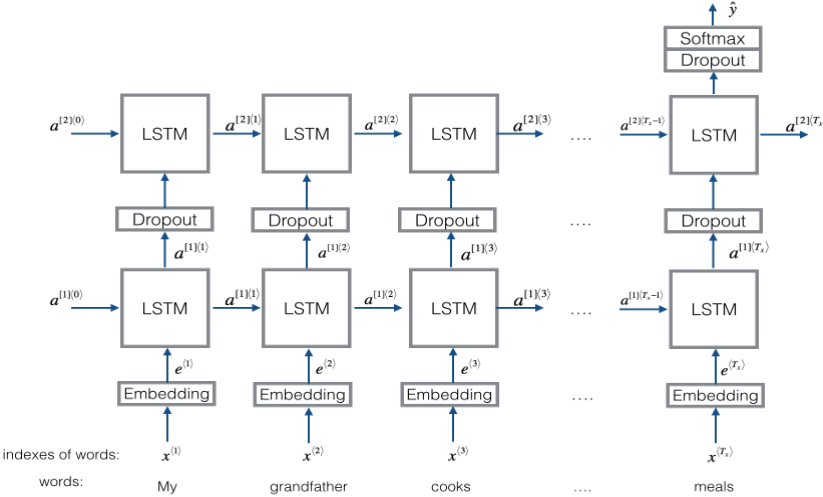

In [58]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):

    #Define sentence_indice as the input of the graph
    sentence_indices = Input(shape=input_shape, dtype='int32')

    #Create the embedding layer pretrained with Glove vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    embeddings = embedding_layer(sentence_indices)


    X = LSTM(units=128, return_sequences=True)(embeddings)

    X = Dropout(0.5)(X)

    X = LSTM(units=128, return_sequences=False)(X)

    X = Dropout(0.5)(X)

    X = Dense(5)(X)

    X = Activation('softmax')(X)

    model = Model(inputs=sentence_indices,outputs=X)

    return model 


In [59]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 10, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 10, 128)        │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,223,927 (77.15 MB)

 Trainable params: 223,877 (874.52 KB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [60]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [62]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2715 - loss: 1.5968
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3344 - loss: 1.5059 
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3409 - loss: 1.4528 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4562 - loss: 1.3435 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5066 - loss: 1.2746 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6112 - loss: 1.0948 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6353 - loss: 0.9551 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6520 - loss: 0.9457 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7760 - loss: 0.7650 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7251 - loss: 0.8046 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7822 - loss: 0.5460 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7691 - loss: 0.5280 
E

In [63]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7961 - loss: 0.5622  

Test accuracy =  0.8035714030265808


In [64]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Expected emoji:😄 prediction: he got a very nice raise	❤️
Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😄 prediction: he is a good friend	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:😞 prediction: go away	⚾
Expected emoji:❤️ prediction: family is all I have	🍴


In [67]:
x_test = np.array(['I am crazy'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
I am crazy 😞
